In [1]:
from alchemyDB import *
from create_objects import *
import sqlalchemy
from sqlalchemy import orm
import time
import pprint
from sqlalchemy.orm import sessionmaker
from sqlalchemy.sql.expression import func
from sqlalchemy import inspect
import pandas as pd

engine = create_engine('sqlite:///boardgames.db')
Session = sessionmaker(bind=engine, autoflush=False)
session = Session()

In [2]:
def game_to_json(o):
    og = vars(o) 
    keys = og.keys()
    extra = ['_sa_instance_state', 'mechanics', 'categories', 'artists']
    
    d = {k: v for k, v in og.items() if k not in extra}
    d['mechanics'] = [m.name for m in o.mechanics]
    d['categories'] = [c.name for c in o.categories]
    d['artists'] = [a.name for a in o.artists]
    
    for k, v in d.items():
        if v == '-100':
            d[k] = None
    
    return d

## MVP lol

In [27]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import mca
nn = NearestNeighbors(n_neighbors=5)
df = pd.read_sql_query("SELECT * FROM games", engine)
relevant = ['id', 'name', 'ratingscount', 'avgrating', 'published',
       'minplayers', 'maxplayers', 'best', 'recommended', 'not_recommended',
       'playingtime', 'minplaytime', 'maxplaytime', 'minage', 'suggestedage',
       'language_dependence']
fullX = df[relevant].apply(lambda x: x.fillna(x.median()) if x.dtype != np.dtype('O') else x,axis=0)
X = fullX.drop(['id', 'name'], axis=1)

In [47]:
df.columns

Index(['id', 'name', 'description', 'ratingscount', 'avgrating', 'published',
       'minplayers', 'maxplayers', 'best', 'recommended', 'not_recommended',
       'playingtime', 'minplaytime', 'maxplaytime', 'minage', 'suggestedage',
       'language_dependence', 'designer', 'publisher'],
      dtype='object')

In [62]:
df.describe()

,id,ratingscount,avgrating,published,minplayers,maxplayers,best,recommended,not_recommended,playingtime,minplaytime,maxplaytime,minage,suggestedage,language_dependence
count,17575.000000,17575.000000,17575.000000,17575.000000,17575.000000,17575.000000,14986.000000,14986.000000,14986.000000,17575.000000,17575.000000,17575.000000,17575.000000,12620.000000,12284.000000
mean,86969.530299,779.042959,5.610719,1983.236131,2.042845,5.556927,3.163753,2.497131,1.820900,96.493826,69.543954,96.493826,9.511522,9.530507,2.049821
std,85437.639898,3112.180494,0.795619,210.212250,0.678682,15.672659,1.474602,1.367246,1.700994,1068.782376,497.092750,1068.782376,3.668426,3.221900,1.223315
min,1.000000,0.000000,0.000000,-3500.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,8037.500000,54.000000,5.509345,1998.000000,2.000000,4.000000,2.000000,1.000000,1.000000,30.000000,20.000000,30.000000,8.000000,8.000000,1.000000
50%,41624.000000,117.000000,5.553720,2009.000000,2.000000,4.000000,3.000000,2.000000,1.000000,45.000000,30.000000,45.000000,10.000000,10.000000,2.000000
75%,164437.000000,371.000000,5.697955,2015.000000,2.000000,6.000000,4.000000,3.000000,2.000000,90.000000,60.000000,90.000000,12.000000,12.000000,3.000000
max,280789.000000,86869.000000,8.599020,2020.000000,10.000000,999.000000,31.000000,22.000000,31.000000,120000.000000,60000.000000,120000.000000,25.000000,22.000000,5.000000


In [ ]:
mca.MCA(df,cols=['artist','mechanics','category'])

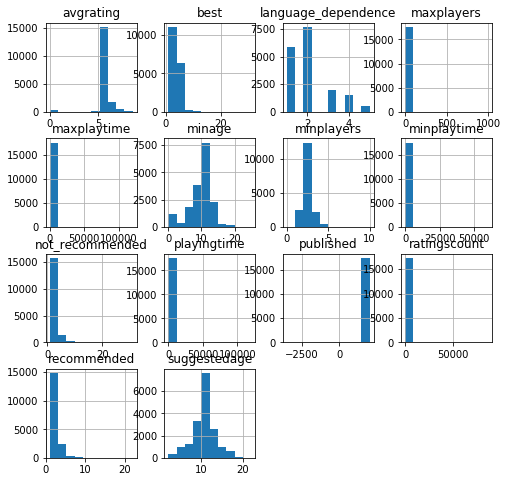

In [60]:
X.hist(figsize=(8,8));
plt.show()

In [74]:
outliers = ['published','avgrating','best','maxplayers','maxplaytime','minplaytime','not_recommended','playingtime','ratingscount','recommended']
normal = ['language_dependence','minage','minplayers','suggestedage']

In [79]:
robust = RobustScaler()
X[outliers] = robust.fit_transform(X[outliers])
minmax = MinMaxScaler()
X[normal] = minmax.fit_transform(X[normal])

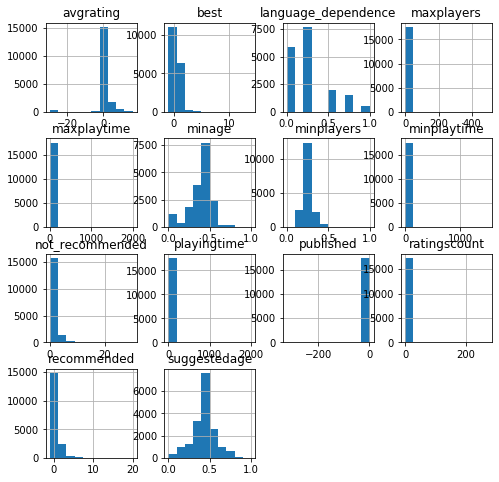

In [80]:
X.hist(figsize=(8,8));
plt.show()

In [81]:
nn.fit(X.values)
pickle.dump(nn, open('testnn.p', 'wb'))

In [82]:
loaded_model = pickle.load(open('testnn.p', 'rb'))

In [88]:
n = 67
test = X[fullX['id'] == n]
test

,ratingscount,avgrating,published,minplayers,maxplayers,best,recommended,not_recommended,playingtime,minplaytime,maxplaytime,minage,suggestedage,language_dependence
63,0.731861,0.58104,-2.058824,0.2,0.0,-0.5,0.0,0.0,1.25,2.25,1.25,0.4,0.5,0.0


In [92]:
n = 67
test = fullX[fullX['id'] == n]
test

,id,name,ratingscount,avgrating,published,minplayers,maxplayers,best,recommended,not_recommended,playingtime,minplaytime,maxplaytime,minage,suggestedage,language_dependence
63,67,Conquest,349,5.66331,1974,2,4,2.0,2.0,1.0,120,120,120,10,12.0,1.0


In [89]:
test.values.reshape(1, -1)

array([[ 0.7318612 ,  0.58104024, -2.05882353,  0.2       ,  0.        ,
        -0.5       ,  0.        ,  0.        ,  1.25      ,  2.25      ,
         1.25      ,  0.4       ,  0.5       ,  0.        ]])

In [90]:
loaded_model.kneighbors(test.values.reshape(1, -1), 6)[-1]

array([[  63, 4109, 2140,  289, 1795, 1469]])

In [91]:
nearest = nn.kneighbors(test.values.reshape(1, -1), 6)[-1]
results = nearest.tolist()[0][1:]
fullX.iloc[results,:]

,id,name,ratingscount,avgrating,published,minplayers,maxplayers,best,recommended,not_recommended,playingtime,minplaytime,maxplaytime,minage,suggestedage,language_dependence
4109,7106,Tabu,112,5.54726,1980,4,4,3.0,2.0,1.0,120,120,120,10,10.0,2.0
2140,2709,The Beastlord,98,5.51765,1979,2,4,3.0,2.0,1.0,120,120,120,12,10.0,2.0
289,330,Block Mania,404,5.71416,1987,2,2,2.0,2.0,1.0,120,120,120,14,12.0,2.0
1795,2160,Robots!,56,5.52649,1980,2,4,1.0,2.0,1.0,120,120,120,10,12.0,2.0
1469,1772,Asteroid,142,5.57904,1980,2,2,2.0,2.0,1.0,120,120,120,10,10.0,2.0


In [37]:
nearest = nn.kneighbors(test.values.reshape(1, -1), 6)[-1]
results = nearest.tolist()[0][1:]
fullX.iloc[results,:]

,id,name,ratingscount,avgrating,published,minplayers,maxplayers,best,recommended,not_recommended,playingtime,minplaytime,maxplaytime,minage,suggestedage,language_dependence
3605,5740,Strat-O-Matic Pro Football,342,5.80789,1968,1,2,2.0,1.0,3.0,120,120,120,11,12.0,3.0
2565,3484,Armada,340,5.42925,1986,2,4,4.0,2.0,5.0,120,120,120,10,12.0,2.0
370,426,The Battle of the Bulge,366,5.71396,1981,2,2,2.0,1.0,3.0,120,120,120,12,12.0,3.0
1298,1558,Rogue Trooper,335,5.59232,1987,2,6,4.0,2.0,1.0,120,120,120,12,12.0,3.0
3088,4454,Statis Pro Football,369,5.67680,1973,1,2,2.0,1.0,3.0,120,120,120,12,12.0,2.0
